In [47]:
# import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow import keras
# from tensorflow.keras import layers, Model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from dataclasses import dataclass
from einops import rearrange, repeat
from typing import Union

from transformers import AutoTokenizer

import datasets
import math
import numpy as np

In [48]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='uniform',
                                              trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='uniform',
                                           trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:, :, :4], axis=-1)
        time_linear = self.weights_linear * x + self.bias_linear  # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1)  # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1)  # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1)  # shape = (batch, seq_len, 2)

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [49]:
@dataclass
class ModelArgs:
    model_input_dims: int = 64
    model_states: int = 64
    projection_expand_factor: int = 2
    conv_kernel_size: int = 4
    delta_t_min: float = 0.001
    delta_t_max: float = 0.1
    delta_t_scale: float = 0.1
    delta_t_init_floor: float = 1e-4
    conv_use_bias: bool = True
    dense_use_bias: bool = False
    layer_id: int = -1
    seq_length: int = 30  # 30 days stock price data
    num_layers: int = 5
    dropout_rate: float = 0.2
    loss: str = 'mse'
    optimizer: str = 'adam'
    metrics = ['mae', 'mape']

    def __post_init__(self):
        self.model_internal_dim: int = int(self.projection_expand_factor * self.model_input_dims)

        self.delta_t_rank = math.ceil(self.model_input_dims/16)
        if self.layer_id == -1:
            self.layer_id = np.round(np.random.randint(0, 1000), 4)


In [50]:
def selective_scan(u, delta, A, B, C, D):
    # first step of A_bar = exp(ΔA), i.e., ΔA
    dA = tf.einsum('bld,dn->bldn', delta, A) 
    dB_u = tf.einsum('bld,bld,bln->bldn', delta, u, B)
    
    dA_cumsum = tf.pad(
        dA[:, 1:], [[0, 0], [1, 1], [0, 0], [0, 0]])[:, 1:, :, :]
    
    dA_cumsum = tf.reverse(dA_cumsum, axis=[1])  # Flip along axis 1
    
    # Cumulative sum along all the input tokens, parallel prefix sum, 
    # calculates dA for all the input tokens parallely
    dA_cumsum = tf.math.cumsum(dA_cumsum, axis=1)  

    # second step of A_bar = exp(ΔA), i.e., exp(ΔA)
    dA_cumsum = tf.exp(dA_cumsum)  
    dA_cumsum = tf.reverse(dA_cumsum, axis=[1])  # Flip back along axis 1

    x = dB_u * dA_cumsum
    # 1e-12 to avoid division by 0
    x = tf.math.cumsum(x, axis=1)/(dA_cumsum + 1e-12) 

    y = tf.einsum('bldn,bln->bld', x, C)
    
    return y + u * D 

In [52]:
class MambaBlock(Layer):  # layers.
    def __init__(self, modelargs: ModelArgs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.args = modelargs
        args = modelargs
        self.layer_id = modelargs.layer_id

#         self.in_projection = layers.Dense(
#             args.model_internal_dim * 2, 
#             input_shape=(args.model_input_dims,), use_bias=False)
        self.in_projection = Dense(
            args.model_internal_dim * 2, 
            input_shape=(args.model_input_dims,), use_bias=False)

#         self.conv1d = layers.Conv1D(
#             filters=args.model_internal_dim,
#             use_bias=args.conv_use_bias,
#             kernel_size=args.conv_kernel_size,
#             groups=args.model_internal_dim,
#             data_format='channels_first',
#             padding='causal'
#         )
        self.conv1d = Conv1D(
            filters=args.model_internal_dim,
            use_bias=args.conv_use_bias,
            kernel_size=args.conv_kernel_size,
            groups=args.model_internal_dim,
            data_format='channels_first',
            padding='causal'
        )

        # this layer takes in current token 'x' 
        # and outputs the input-specific Δ, B, C (according to S6)
#         self.x_projection = layers.Dense(args.delta_t_rank + args.model_states * 2, use_bias=False)
        self.x_projection = Dense(args.delta_t_rank + args.model_states * 2, use_bias=False)

        # this layer projects Δ from delta_t_rank to the mamba internal 
        # dimension
#         self.delta_t_projection = layers.Dense(args.model_internal_dim, 
#                                                input_shape=(args.delta_t_rank,), use_bias=True)
        self.delta_t_projection = Dense(args.model_internal_dim, 
                                               input_shape=(args.delta_t_rank,), use_bias=True)

        self.A = repeat(
                tf.range(1, args.model_states+1, dtype=tf.float32), 
                'n -> d n', d=args.model_internal_dim)

        self.A_log = tf.Variable(
                tf.math.log(self.A), 
                trainable=True, dtype=tf.float32, 
                name=f"SSM_A_log_{args.layer_id}")

        self.D = tf.Variable(
                np.ones(args.model_internal_dim), 
                trainable=True, dtype=tf.float32, 
                name=f"SSM_D_{args.layer_id}")

#         self.out_projection = layers.Dense(
#                 args.model_input_dims, 
#                 input_shape=(args.model_internal_dim,), 
#                 use_bias=args.dense_use_bias)
        self.out_projection = Dense(
                args.model_input_dims, 
                input_shape=(args.model_internal_dim,), 
                use_bias=args.dense_use_bias)

    def call(self, x):
        """Mamba block forward. This looks the same as Figure 3 in Section 3.4 in the Mamba pape.
        Official Implementation:
            class Mamba, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L119
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311
        """

        (batch_size, seq_len, dimension) = x.shape

        x_and_res = self.in_projection(x) # shape = (batch, seq_len, 2 * model_internal_dimension)
        (x, res) = tf.split(x_and_res, 
                            [self.args.model_internal_dim, 
                             self.args.model_internal_dim], axis=-1)
        
        x = rearrange(x, 'b l d_in -> b d_in l')
        x = self.conv1d(x)[:, :, :seq_len]
        x = rearrange(x, 'b d_in l -> b l d_in')
        
        x = tf.nn.swish(x)
        y = self.ssm(x)
        y = y * tf.nn.swish(res)
        return self.out_projection(y)
    
    def ssm(self, x):
        """Runs the SSM. See:
            - Algorithm 2 in Section 3.2 in the Mamba paper
            - run_SSM(A, B, C, u) in The Annotated S4
            Official Implementation:
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311
        """
        (d_in, n) = self.A_log.shape

        # Compute ∆ A B C D, the state space parameters.
        #     A, D are input independent (see Mamba paper [1] Section 3.5.2 "Interpretation of A" for why A isn't selective)
        #     ∆, B, C are input-dependent (this is a key difference between Mamba and the linear time invariant S4,
        #                                  and is why Mamba is called **selective** state spaces)

        A = -tf.exp(tf.cast(self.A_log, tf.float32)) # shape -> (d_in, n)
        D = tf.cast(self.D, tf.float32)

        x_dbl = self.x_projection(x) # shape -> (batch, seq_len, delta_t_rank + 2*n)

        (delta, B, C) = tf.split(
                x_dbl, 
                num_or_size_splits=[self.args.delta_t_rank, n, n], 
                axis=-1) # delta.shape -> (batch, seq_len) & B, C shape -> (batch, seq_len, n)

        delta = tf.nn.softplus(self.delta_t_projection(delta)) # shape -> (batch, seq_len, model_input_dim)

        return selective_scan(x, delta, A, B, C, D)

In [53]:
class ResidualBlock(Layer):  # layers.
    def __init__(self, modelargs: ModelArgs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.args = modelargs
        self.mixer = MambaBlock(modelargs)
        self.norm = LayerNormalization(epsilon=1e-5)  # layers.  deleted

    def call(self, x):
        """
        Official Implementation:
            Block.forward(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L297
            
            Note: the official repo chains residual blocks that look like
                [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> ...
            where the first Add is a no-op. This is purely for performance reasons as this
            allows them to fuse the Add->Norm.

            We instead implement our blocks as the more familiar, simpler, and numerically equivalent
                [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> ....
            
        """
        return self.mixer(self.norm(x)) + x

In [54]:
def init_model(args: ModelArgs):
    time_embedding = Time2Vector(args.seq_length)
    
    input_layer = Input(shape=(args.seq_length, 1), name='input_ids') # layers.
    # x = input_layer
    # input_layer = Input(shape=(args.seq_length,), name='input_ids') # layers.
    x = time_embedding(input_layer)
    
    # x = Embedding(
    #             751, 
    #             args.model_input_dims)(input_layer)
    
    x = Concatenate(axis=-1)([input_layer, x]) # layers.

    for i in range(args.num_layers):
        x = ResidualBlock(args, name=f"Residual_{i}")(x)
        x = Dropout(args.dropout_rate)(x) # for regularization  # layers.

    # x = LayerNormalization(epsilon=1e-5)(x) # normalization layer  # layers.
    
    # x = Flatten()(x) # layers.

    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    # x = Dense(64, activation=tf.nn.gelu)(x)  # layers.
    # x = Dropout(0.1)(x)                     # consider to use args.dropout  # layers.
    output_layer = Dense(1, activation='linear')(x)  # layers.

    model = Model(
                inputs=[input_layer], 
                outputs=[output_layer], name='Mamba_ka_Mamba')
    model.compile(
        loss=args.loss,
        optimizer=args.optimizer,
        metrics=args.metrics
    )

    return model

In [115]:
args = ModelArgs(
    model_input_dims=3,
    model_states=32,
    num_layers=5,
    dropout_rate=0.1,
#     vocab_size=vocab_size,
#     num_classes=1,
#     loss='binary_crossentropy',
)
model = init_model(args)
model.summary()

/home/henrycheng/python_workspace/notebookenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Mamba_ka_Mamba"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vector_18     │ (None, 30, 2)     │        120 │ input_ids[0][0]   │
│ (Time2Vector)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 30, 3)     │          0 │ input_ids[0][0],  │
│ (Concatenate)       │                   │            │ time2_vector_18[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Residual_0          │ (None, 30, 3)     │        492 │ concatenate_18[0… │
│ (ResidualBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_133         │ (None, 30, 3)     │          0 │ Residual_0[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Residual_1          │ (None, 30, 3)     │        492 │ dropout_133[0][0] │
│ (ResidualBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_134         │ (None, 30, 3)     │          0 │ Residual_1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Residual_2          │ (None, 30, 3)     │        492 │ dropout_134[0][0] │
│ (ResidualBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_135         │ (None, 30, 3)     │          0 │ Residual_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Residual_3          │ (None, 30, 3)     │        492 │ dropout_135[0][0] │
│ (ResidualBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_136         │ (None, 30, 3)     │          0 │ Residual_3[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Residual_4          │ (None, 30, 3)     │        492 │ dropout_136[0][0] │
│ (ResidualBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_137         │ (None, 30, 3)     │          0 │ Residual_4[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 30)        │          0 │ dropout_137[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_138         │ (None, 30)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_438 (Dense)   │ (None, 64)        │      1,984 │ dropout_138[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_139         │ (None, 64)        │          0 │ dense_438[0][0]   │
│ (Dropout)           │                   │            │                 

 Total params: 4,629 (18.08 KB)

 Trainable params: 4,629 (18.08 KB)

 Non-trainable params: 0 (0.00 B)

In [116]:
from datetime import datetime
import pandas as pd

tsmc_data = pd.read_csv('./tsmc_stock_prices_INT_open_only_datetime_2010-2023.csv')
tsmc_data.index = tsmc_data["date"]
tsmc_data = tsmc_data.drop(columns=["date"])
print(tsmc_data.head())

                     open
date                     
2010-01-04 00:00:00    65
2010-01-05 00:00:00    65
2010-01-06 00:00:00    64
2010-01-07 00:00:00    64
2010-01-08 00:00:00    63


In [117]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

input_length = 30
output_length = 1
dataset = tsmc_data['open'].to_numpy()

scaler = MinMaxScaler()
dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list = []
for i in range(len(dataset) - input_length - output_length):
    dataset_list.append(dataset_norm[i:i + input_length + output_length])
dataset_list = np.array(dataset_list)

split_idx_train = int(len(dataset_list) * 0.8)
split_idx_val = int(len(dataset_list) * 0.9)

x_train = dataset_list[:split_idx_train, :-1]
y_train = dataset_list[:split_idx_train, -1:]

x_val = dataset_list[split_idx_train:split_idx_val, :-1]
y_val = dataset_list[split_idx_train:split_idx_val, -1:]

x_test = dataset_list[split_idx_val:, :-1]
y_test = dataset_list[split_idx_val:, -1:]

print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_val.shape:', x_val.shape)
print('y_val.shape:', y_val.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)


x_train.shape: (2718, 30)
y_train.shape: (2718, 1)
x_val.shape: (340, 30)
y_val.shape: (340, 1)
x_test.shape: (340, 30)
y_test.shape: (340, 1)


In [118]:
from keras.callbacks import EarlyStopping


history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=200,
                    validation_data=(x_val, y_val),
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 304ms/step - loss: 0.1014 - mae: 0.2416 - mape: 238.1599 - val_loss: 0.2907 - val_mae: 0.5621 - val_mape: 67.5294
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 0.0230 - mae: 0.1008 - mape: 156.9148 - val_loss: 0.0070 - val_mae: 0.0861 - val_mape: 10.1337
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 0.0091 - mae: 0.0737 - mape: 188.1811 - val_loss: 0.0022 - val_mae: 0.0312 - val_mape: 3.9273
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - loss: 0.0059 - mae: 0.0560 - mape: 115.8748 - val_loss: 0.0017 - val_mae: 0.0362 - val_mape: 4.3186
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0063 - mae: 0.0531 - mape: 93.5284 - val_loss: 0.0015 - val_mae: 0.0320 - val_mape: 3.8531
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0052 - mae: 0.0476 - mape: 94.5643 - val_loss: 0.0015 - val_mae: 0.0331 - val_mape: 3.9780
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - loss: 0.0049 - 

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


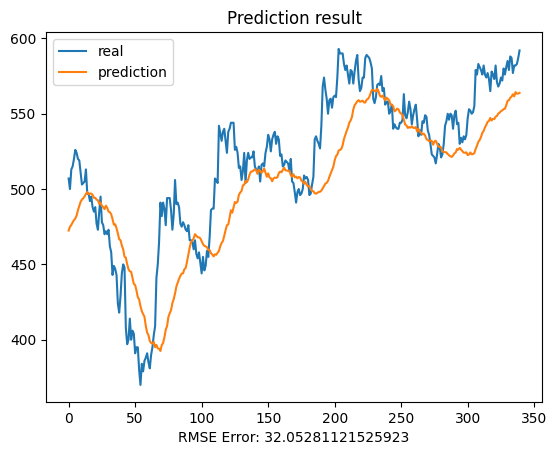

In [119]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
# plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
rmse = np.sqrt(mean_squared_error(y_real, y_predict))
plt.xlabel('RMSE Error: {}'.format(rmse))
plt.legend()
plt.title('Prediction result')
plt.show()

In [120]:
model.save_weights('./mamba_open_checkpoint.weights.h5')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


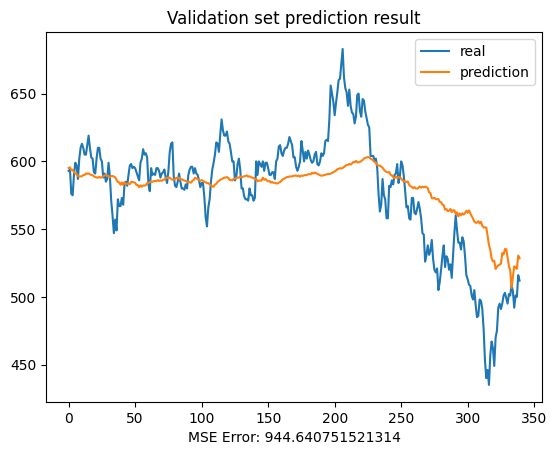

In [48]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

y_predict = model.predict(x_val)
y_real = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Validation set prediction result')
plt.show()

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


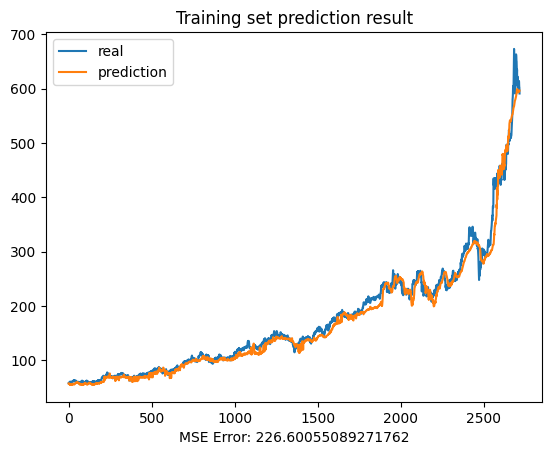

In [49]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

y_predict = model.predict(x_train)
y_real = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Training set prediction result')
plt.show()